In [1]:
import os
import json
import gzip

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.Seq import Seq
from sqlalchemy import create_engine

if os.getcwd().endswith('notebook'):
    os.chdir('..')
    
from preprocessing.sequence_utils import is_valid_cds

In [2]:
sns.set(palette='colorblind', font_scale=1.3)

In [3]:
db_path = os.path.join(os.getcwd(), 'data/db/seq.db')
engine = create_engine(f'sqlite+pysqlite:///{db_path}')

## Number of sequences

In [4]:
seq_per_species_query = """
select 
    assembly_accession, 
    count(*) as sequence_count,
    min(length) as min_length,
    max(length) as max_length,
    avg(length) as avg_length
from sequences
group by assembly_accession
""" 
sequence_count_per_species = pd.read_sql(seq_per_species_query, engine).set_index('assembly_accession', drop=True)

In [5]:
sequence_count_per_species.head()

,sequence_count,min_length,max_length,avg_length
assembly_accession,,,,
GCA_000005825.2,6374,1,15209,815.123157
GCA_000005845.2,6667,1,15867,827.127944
GCA_000006175.2,2784,1,11153,801.007902
GCA_000006605.1,3169,1,19006,949.865573
GCA_000006685.1,1411,1,10208,917.391212


In [6]:
min_s = sequence_count_per_species['sequence_count'].min()
max_s = sequence_count_per_species['sequence_count'].max()
avg_s = sequence_count_per_species['sequence_count'].mean()
print('Sequence count')
print(f'Minimum: {min_s:,}')
print(f'Maximum: {max_s:,}')
print(f'Mean: {avg_s:,.0f}')

Sequence count
Minimum: 194
Maximum: 21,020
Mean: 5,135


In [44]:
sequence_count_per_species.loc['GCA_000828855.1']

sequence_count      259.000000
min_length            1.000000
max_length        34892.000000
avg_length         2678.664093
Name: GCA_000828855.1, dtype: float64

In [41]:
sequence_count_per_species.sort_values('max_length', ascending=False)

,sequence_count,min_length,max_length,avg_length
assembly_accession,,,,
GCA_000013845.2,194,3,672255,15258.185567
GCA_007830355.1,2465,1,329560,1544.011765
GCA_001691185.1,230,13,231881,22746.456522
GCA_001281045.1,404,1,168605,2929.965347
GCA_002804225.1,302,1,164065,2790.443709
...,...,...,...,...
GCA_000474195.1,6425,1,5667,575.901167
GCA_900128875.1,5012,1,5540,649.614725
GCA_001587495.1,5493,1,5232,553.833060


## Sequence lengths

In [7]:
min_s = sequence_count_per_species['min_length'].min()
max_s = sequence_count_per_species['max_length'].max()
print('Sequence length')
print(f'Minimum: {min_s:,}')
print(f'Maximum: {max_s:,}')

Sequence length
Minimum: 1
Maximum: 672,255


In [8]:
avg_sequence_length = pd.read_sql(
    'select avg(length) as avg_seq_l from sequences', 
    engine,
).iloc[0]['avg_seq_l']
print(f'Average sequence length: {avg_sequence_length:,.0f}')

Average sequence length: 869


In [9]:
sequence_lengths = pd.read_sql('select length from sequences', engine)['length'].values

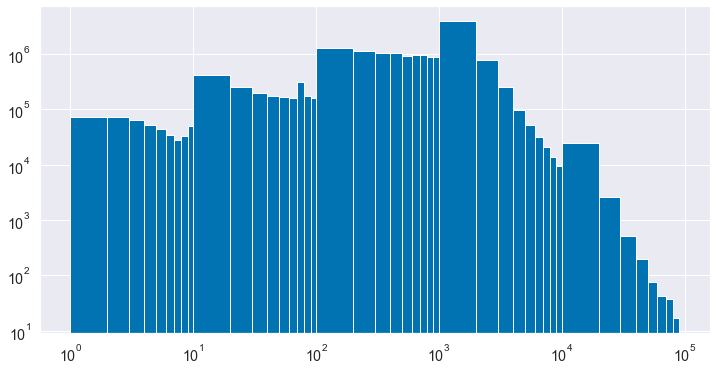

In [10]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
bins = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 
    10, 20, 30, 40, 50, 60, 70, 80, 90, 
    100, 200, 300, 400, 500, 600, 700, 800, 900, 
    1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 
    10e3, 20e3, 30e3, 40e3, 50e3, 60e3, 70e3, 80e3, 90e3,
]
ax.set_xscale('log');
ax.hist(sequence_lengths, bins=bins, log=True);

In [11]:
q = """
select 
    assembly_accession, 
    cast(sum(length) / 1000 as integer) as cds_total_length
from sequences
where sequence_type = 'CDS'
group by assembly_accession
""" 
s1 = pd.read_sql(q, engine)

In [12]:
q = """
select 
    assembly_accession, 
    cast(sum(length) / 1000 as integer) as non_coding_total_length
from sequences
where sequence_type = 'non_coding'
group by assembly_accession
""" 
s2 = pd.read_sql(q, engine)

In [13]:
s = pd.merge(s1, s2, on='assembly_accession').set_index('assembly_accession', drop=True)
s.head()

,cds_total_length,non_coding_total_length
assembly_accession,,
GCA_000005825.2,3609,1546
GCA_000005845.2,4032,1433
GCA_000006175.2,1535,682
GCA_000006605.1,2212,778
GCA_000006685.1,971,310


In [14]:
s['coding_ratio'] = s.apply(
    lambda row: row['cds_total_length'] / (row['cds_total_length'] + row['non_coding_total_length']), 
    axis=1,
)

In [15]:
s

,cds_total_length,non_coding_total_length,coding_ratio
assembly_accession,,,
GCA_000005825.2,3609,1546,0.700097
GCA_000005845.2,4032,1433,0.737786
GCA_000006175.2,1535,682,0.692377
GCA_000006605.1,2212,778,0.739799
GCA_000006685.1,971,310,0.758002
...,...,...,...
GCA_901542335.1,1908,817,0.700183
GCA_901543175.1,1714,740,0.698452
GCA_901543605.1,1541,714,0.683370


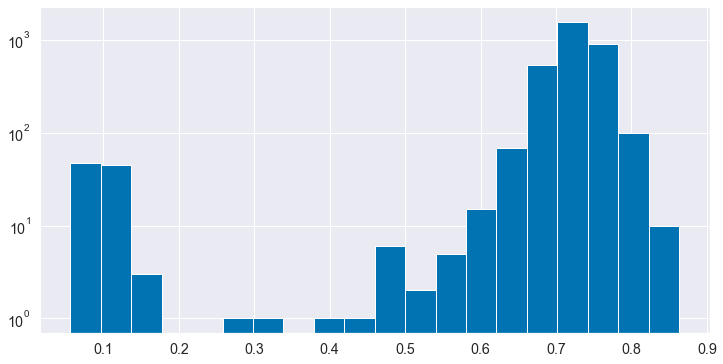

In [16]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(s['coding_ratio'], bins=20, log=True);